# マルコフ連鎖モンテカルロ法 (MCMC)
前節では解析的に事後分布の計算をした．事後分布を近似的に推論する方法の1つに**マルコフ連鎖モンテカルロ法 (Markov chain Monte Carlo methods; MCMC)** がある．他の近似推論の手法としてはLaplace近似や変分推論（variational inference）などがある．MCMCは他の手法に比して，事後分布の推論だけでなく，確率分布を神経活動で表現する方法を提供するという利点がある．

```{note}
変分推論は入れた方がいいと思うが，紙幅の都合上いれられるか微妙である．
```

データを$X$とし，パラメータを$\theta$とする．

$$
p(\theta\mid X)=\frac{p(X\mid \theta)p(\theta)}{\int p(X\mid \theta)p(\theta)d\theta}
$$

分母の積分計算$\int p(X\mid \theta)p(\theta)d\theta$が求まればよい．

### モンテカルロ法

### マルコフ連鎖

## ハミルトニアン・モンテカルロ法 (HMC法)
ハミルトニアン・モンテカルロ法(Hamiltonian Monte Calro)あるいはハイブリッド・モンテカルロ法(Hybrid Monte Calro)という

一般化座標を$\mathbf{q}$, 一般化運動量を$\mathbf{p}$とする．ポテンシャルエネルギーを$U(\mathbf{q})$としたとき，古典力学（解析力学）において保存力のみが作用する場合の**ハミルトニアン (Hamiltonian)** $\mathcal{H}(\mathbf{q}, \mathbf{p})$は

$$
\mathcal{H}(\mathbf{q}, \mathbf{p}):=U(\mathbf{q})+\frac{1}{2}\|\mathbf{p}\|^2
$$

となる．このとき，次の2つの方程式が成り立つ．

$$
\frac{d\mathbf{q}}{dt}=\frac{\partial \mathcal{H}}{\partial \mathbf{p}}=\mathbf{p},\quad\frac{d\mathbf{p}}{dt}=-\frac{\partial \mathcal{H}}{\partial \mathbf{q}}=-\frac{\partial U}{\partial \mathbf{q}}
$$

これを**ハミルトンの運動方程式(hamilton's equations of motion)** あるいは**正準方程式 (canonical equations)** という．


この処理をMetropolis-Hastings法における採用・不採用アルゴリズムという．

リープフロッグ(leap frog)法により離散化する．

In [1]:
using Base: @kwdef
using Parameters: @unpack
using PyPlot, LinearAlgebra, Random, Distributions
rc("axes.spines", top=false, right=false)

In [2]:
using ForwardDiff
using KernelDensity

In [3]:
function leapfrog(grad::Function, θ::Vector{Float64}, p::Vector{Float64}, ϵ::Float64, L::Int)
    for l in 1:L
        p += 0.5 * ϵ * grad(θ)
        θ += ϵ * p
        p += 0.5 * ϵ * grad(θ)
    end
    return θ, p
end;

In [4]:
# Hamiltonian Monte Carlo method; log_p: unnormalized log-posterior
function HMC(log_p::Function, θ_init::Vector{Float64}, ϵ::Float64, L::Int, num_iter::Int)
    grad(θ)= ForwardDiff.gradient(log_p, θ)
    d = length(θ_init)
    samples = zeros(d, num_iter)
    num_accepted = 0
    θ = θ_init # init position
    for m in 1:num_iter
        p = randn(d) # get momentum        
        H = -log_p(θ) + 0.5 * p' * p        # initial Hamiltonian
        θ_, p_ = leapfrog(grad, θ, p, ϵ, L) # update
        H_ = -log_p(θ_) + 0.5 * p_' * p_    # final Hamiltonian
        
        if min(1, exp(H - H_)) > rand()
            θ = θ_ # accept
            num_accepted += 1
        end
        samples[:, m] = θ
    end
    return samples, num_accepted
end;

In [5]:
mixed_gauss = MixtureModel([MvNormal(zeros(2), I), MvNormal(3*ones(2), I)], [0.5, 0.5]) # 分布を混ぜる

MixtureModel{IsoNormal}(K = 2)
components[1] (prior = 0.5000): IsoNormal(
dim: 2
μ: [0.0, 0.0]
Σ: [1.0 0.0; 0.0 1.0]
)

components[2] (prior = 0.5000): IsoNormal(
dim: 2
μ: [3.0, 3.0]
Σ: [1.0 0.0; 0.0 1.0]
)



In [6]:
x = -3:0.1:6
pd(x₁, x₂) = logpdf(mixed_gauss, [x₁, x₂])

pd (generic function with 1 method)

In [7]:
mixed_gauss_heat = pd.(x, x');

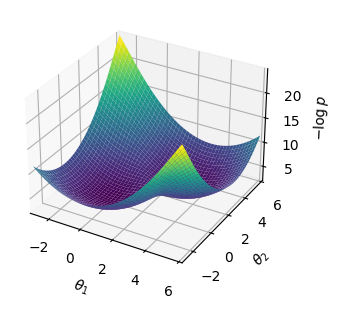

In [23]:
xpos = x * ones(size(x))'

fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(projection="3d")
surf = ax.plot_surface(xpos, xpos', -mixed_gauss_heat, cmap="viridis")
ax.set_xlim(-3, 6); ax.set_ylim(-3, 6); 
ax.set_xlabel(L"$\theta_1$"); ax.set_ylabel(L"$\theta_2$"); ax.set_zlabel(L"$-\log p$"); 
tight_layout()

In [9]:
log_p(θ) = logpdf(mixed_gauss, θ);

In [10]:
grad(θ)= ForwardDiff.gradient(log_p, θ)

grad (generic function with 1 method)

In [11]:
nt = 10000

10000

In [12]:
ϵ = 0.1

0.1

In [13]:
ps = zeros(nt, 2)
θs = zeros(nt, 2)
p = randn(2)
θ = randn(2)
for t in 1:nt
    if t in 20:10:nt
        p = randn(2)
    end
    p += 0.5 * ϵ * grad(θ)
    θ += ϵ * p
    p += 0.5 * ϵ * grad(θ)
    ps[t, :] = p
    θs[t, :] = θ
end

In [14]:
Us = kde((θs[:, 1], θs[:, 2]));

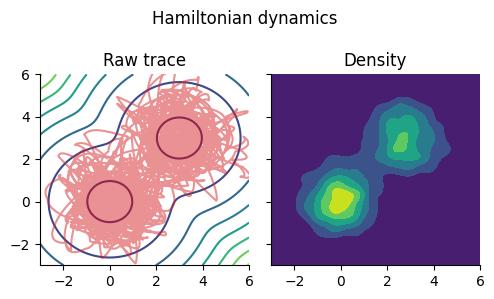

In [37]:
fig, ax = subplots(1, 2, figsize=(5, 3), sharex="all", sharey="all")
fig.suptitle("Hamiltonian dynamics")
ax[1].set_title("Raw trace")
ax[1].contour(x, x, -mixed_gauss_heat)
ax[1].plot(θs[:, 1], θs[:, 2], color="tab:red", alpha=0.5)
ax[1].set_xlim(-3,6); ax[1].set_ylim(-3,6)
ax[2].set_title("Density")
ax[2].contourf(Us.x, Us.x, Us.density)
fig.tight_layout()

## ランジュバン・モンテカルロ法 (LMC)
http://watanabe-www.math.dis.titech.ac.jp/~kohashi/document/bayes_51.pdf

https://qiita.com/karadaharu/items/6c015ec99f30667808f2

https://en.wikipedia.org/wiki/Metropolis-adjusted_Langevin_algorithm

拡散過程

$$
{\frac{d\theta}{dt}}=\nabla \log p (\theta)+{\sqrt 2}{d{W}}
$$

Euler–Maruyama法により，

In [16]:
β = 1
ρ = sqrt(2*ϵ);

In [17]:
θl = zeros(nt, 2)
θ = [1.0,0.5]
for t in 1:nt
    θ += ϵ * β * grad(θ) + ρ * randn(2)
    θl[t, :] = θ
end

In [18]:
Ul = kde((θl[:, 1], θl[:, 2]));

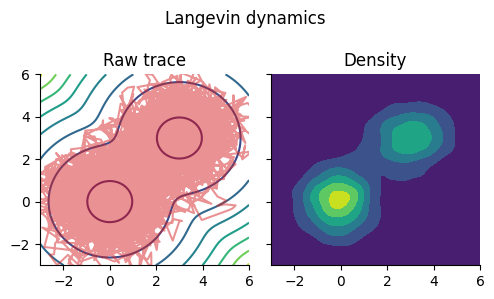

In [36]:
fig, ax = subplots(1, 2, figsize=(5, 3), sharex="all", sharey="all")
fig.suptitle("Langevin dynamics")
ax[1].set_title("Raw trace")
ax[1].contour(x, x, -mixed_gauss_heat)
ax[1].plot(θl[:, 1], θl[:, 2], color="tab:red", alpha=0.5)
ax[1].set_xlim(-3,6); ax[1].set_ylim(-3,6)
ax[2].set_title("Density")
ax[2].contourf(Ul.x, Ul.x, Ul.density)
fig.tight_layout()

## 線形回帰への適応